# CNN for Cancer Detection
**Binary image classification of metastatic cancer in tissue samples using a convolutional neural network (CNN).**

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
i = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        i += 1
        if i> 10:
            break
        print(os.path.join(dirname, filename))
    if i > 10:
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/histopathologic-cancer-detection/sample_submission.csv
/kaggle/input/histopathologic-cancer-detection/train_labels.csv
/kaggle/input/histopathologic-cancer-detection/test/a7ea26360815d8492433b14cd8318607bcf99d9e.tif
/kaggle/input/histopathologic-cancer-detection/test/59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
/kaggle/input/histopathologic-cancer-detection/test/5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
/kaggle/input/histopathologic-cancer-detection/test/bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
/kaggle/input/histopathologic-cancer-detection/test/523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif
/kaggle/input/histopathologic-cancer-detection/test/d23c66547f4a00555a174d2fcb860ae399b66edc.tif
/kaggle/input/histopathologic-cancer-detection/test/fabf2fca23f71655974767e29eda86a9b2c97a72.tif
/kaggle/input/histopathologic-cancer-detection/test/9730b15862516b8641b9f0ff48db660d95031c32.tif


In [2]:
!pwd
!ls -l 

/kaggle/working
total 36
---------- 1 root root 36304 Sep 14 17:12 __notebook__.ipynb


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense, Multiply, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

2025-09-14 17:12:09.831594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757869930.045476      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757869930.105213      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Define directories
directory  = '../input/histopathologic-cancer-detection'  
labels_path = os.path.join(directory, 'train_labels.csv')
train_path = os.path.join(directory, 'train')
test_path = os.path.join(directory, 'test')

In [5]:
print('There are ',len(os.listdir(train_path)), 'training images and ',len(os.listdir(test_path)), 'testing images.')

There are  220025 training images and  57458 testing images.


In [6]:
# load the CSV file containing labels
labels = pd.read_csv(labels_path)

# create a DataFrame to match training data images with labels
train = pd.DataFrame({'path': glob(os.path.join(train_path, '*.tif'))}) 
train['id'] = train['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])  # Extract image ID to merge with training labels
train = train.merge(labels, on='id')  

# convert labels to strings
train['label'] = train['label'].astype(str)

# ensure paths are relative to train_path
train['path'] = train['path'].apply(lambda x: os.path.basename(x))

print(train.head())

                                           path  \
0  d43c081bafa286f9c1f7e921883f26ceafebc912.tif   
1  092d0eedebce504847715ee046b6ad74b57599b4.tif   
2  b0d2582c6218a8764323fc940b41312282b99bf4.tif   
3  187c99df762f13f99818e5593d4bab4c6577e7e3.tif   
4  7c5270c83837de5a5cbb2dca511559dc39d19d53.tif   

                                         id label  
0  d43c081bafa286f9c1f7e921883f26ceafebc912     1  
1  092d0eedebce504847715ee046b6ad74b57599b4     0  
2  b0d2582c6218a8764323fc940b41312282b99bf4     0  
3  187c99df762f13f99818e5593d4bab4c6577e7e3     1  
4  7c5270c83837de5a5cbb2dca511559dc39d19d53     1  


## Data Exploration

<Axes: xlabel='label'>

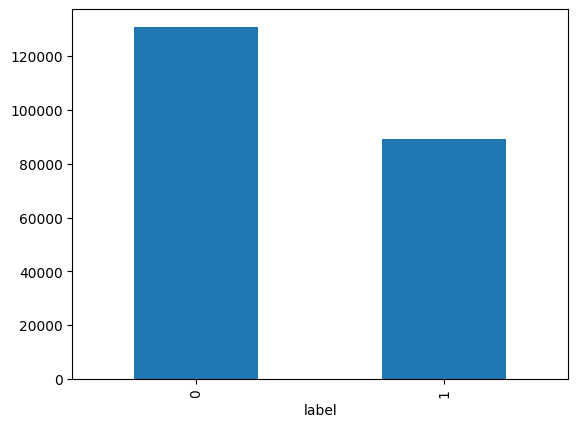

In [7]:
# Check for nulls
train[(train['id'].isnull() | train['path'].isnull())]
# check for counts of 0 and 1 labels
train.groupby(by='label')['id'].count().plot(kind='bar')

The dataset seems to be reasonably balanced (120k vs 80k). We will not try to resample it.

In [8]:
# check for duplicates
print('There are ', train.duplicated().sum(),' duplicated images')

There are  0  duplicated images


Image shape is  (96, 96, 3)
The maximum number of pixels is  255
[68 35 86]


,path,id,label
156982,e4b175945c804ec9998662b68e4427ed9c8375d3.tif,e4b175945c804ec9998662b68e4427ed9c8375d3,0


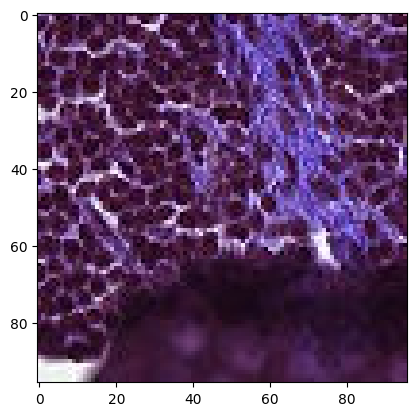

In [9]:
# randomly select one image path
image_path = random.choice(train['path'].values)
# full path to the image
full_image_path = os.path.join(train_path, image_path)
# Load the selected image 
selected_image = cv2.imread(full_image_path)

print('Image shape is ', selected_image.shape)
print('The maximum number of pixels is ', selected_image.max())

# Print 1 pixel
print(selected_image[1,1,:])
plt.imshow(selected_image)
train[train['path'] == image_path] #.split('.')[0]

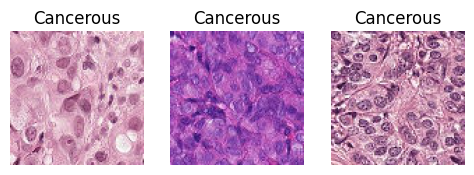

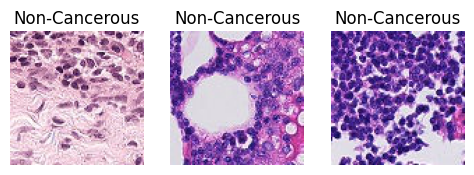

In [10]:
# Separate cancerous and non-cancerous data
cancerous = train[train['label'] == '1']['id'].sample(n=3).values  # Treat labels as strings
noncancerous = train[train['label'] == '0']['id'].sample(n=3).values

cancerous_images = []
for id in cancerous:
    image_path = os.path.join(train_path, id + '.tif')
    cancerous_images.append(Image.open(image_path))

noncancerous_images = []
for id in noncancerous:
    image_path = os.path.join(train_path, id + '.tif')
    noncancerous_images.append(Image.open(image_path))

plt.figure(figsize=(10, 5))
for i, image in enumerate(cancerous_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title('Cancerous')
    plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
for i, image in enumerate(noncancerous_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title('Non-Cancerous')
    plt.axis('off')
plt.show()

## Data Generation

The original dataset with more than 220k images takes a lot of time, and sometimes never finishes. We will resample the data
and only grap 50k from each set



In [11]:
from sklearn.utils import shuffle

c_df = train[train['label'] == '1'].sample(50000, random_state=42)
nc_df = train[train['label'] == '0'].sample(50000, random_state=42)

train_100k = pd.concat([c_df, nc_df], axis = 0).reset_index(drop = True)
train_100k = shuffle(train_100k)
train_100k.shape
                       

(100000, 3)

In [12]:
# Split the data into 80% training and 20% validation sets
train_df, val_df = train_test_split(train_100k, test_size=0.2, random_state=42)

# Data generator for training images
train_datagen = ImageDataGenerator(
    rescale=1./255  # scale images from 0-255 to 0-1 
)

# Data generator for validation images without augmentation
validation_datagen = ImageDataGenerator(
    rescale=1./255  # scale images from 0-255 to 0-1
)

batch_size = 64

# Generator for the training set
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_path,
    x_col='path',
    y_col='label',
    target_size=(96, 96), # image shape
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Generator for the validation set
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,  
    directory=train_path,
    x_col='path',
    y_col='label',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 80000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


### Base custom model
Lets try a very simple base model first.

In [13]:
cnn_baseline = Sequential([
    Conv2D(filters = 32, kernel_size = [3,3], padding = 'same', activation = 'relu', input_shape = (96,96,3)),
    Conv2D(filters = 32, kernel_size = [3,3], padding = 'same', activation = 'relu'),
    MaxPooling2D(2,2),
    Dropout(.2),
    BatchNormalization(),

    Conv2D(filters = 64, kernel_size = [3,3], padding = 'same', activation = 'relu'),
    Conv2D(filters = 64, kernel_size = [3,3], padding = 'same', activation = 'relu'),
    Conv2D(filters = 64, kernel_size = [3,3], padding = 'same', activation = 'relu'),
    MaxPooling2D(2,2),
    Dropout(.2),
    BatchNormalization(),

    Conv2D(filters = 128, kernel_size = [5,5], padding = 'same', activation = 'relu'),
    Conv2D(filters = 128, kernel_size = [5,5], padding = 'same', activation = 'relu'),
    Conv2D(filters = 128, kernel_size = [3,3], padding = 'same', activation = 'relu'),
    MaxPooling2D(2,2),
    Dropout(.2),
    BatchNormalization(),

    Flatten(),
    
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

cnn_baseline.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1757870320.327896      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,2

 Total params: 3,235,425 (12.34 MB)

 Trainable params: 3,234,977 (12.34 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
%%time
TR_STEPS = len(train_generator)
VAL_STEPS = len(validation_generator)
print(TR_STEPS)
print(VAL_STEPS)
opt = tf.keras.optimizers.Adam(learning_rate = .001)
cnn_baseline.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['AUC'])

h1 = cnn_baseline.fit(
    x = train_generator,
    steps_per_epoch = TR_STEPS,
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = VAL_STEPS,
    verbose = 1,
)


1250
313


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1757870330.312509      62 service.cc:148] XLA service 0x79ab3c002290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757870330.313307      62 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757870331.093638      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1250 ━━━━━━━━━━━━━━━━━━━━ 5:39:16 16s/step - AUC: 0.3954 - loss: 1.0175

I0000 00:00:1757870339.345323      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 891s 700ms/step - AUC: 0.8617 - loss: 0.4674 - val_AUC: 0.9300 - val_loss: 0.3521
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 137s 109ms/step - AUC: 0.9189 - loss: 0.3627 - val_AUC: 0.8051 - val_loss: 0.6160
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 118s 94ms/step - AUC: 0.9364 - loss: 0.3223 - val_AUC: 0.9433 - val_loss: 0.5017
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 116s 93ms/step - AUC: 0.9502 - loss: 0.2855 - val_AUC: 0.9300 - val_loss: 0.4017
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 118s 94ms/step - AUC: 0.9590 - loss: 0.2582 - val_AUC: 0.9347 - val_loss: 0.3928
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 117s 94ms/step - AUC: 0.9676 - loss: 0.2280 - val_AUC: 0.9454 - val_loss: 0.3545
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 119s 95ms/step - AUC: 0.9715 - loss: 0.2121 - val_AUC: 0.9704 - val_loss: 0.2617
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 116s 93ms/step - AUC: 0.9757 - loss: 0.1953 - val_AUC: 0.9600 - val_loss: 0.2700
Epoch 9/50
1250/1250 ━━━━

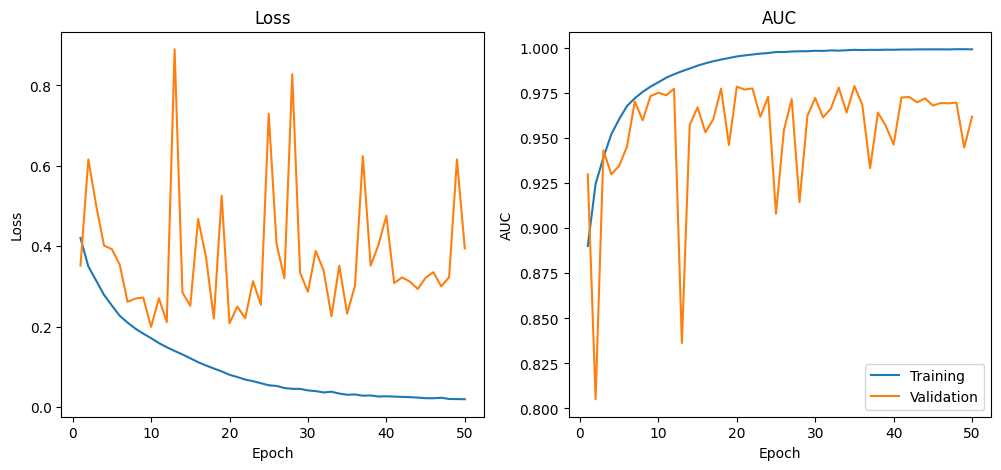

In [15]:
history = h1.history

epoch_range = range(1, len(history['loss'])+1)
plt.figure(figsize = [12,5])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label = 'Training')
plt.plot(epoch_range, history['val_loss'], label = 'Validation')
plt.xlabel('Epoch');plt.ylabel('Loss');plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(epoch_range, history['AUC'], label = 'Training')
plt.plot(epoch_range, history['val_AUC'], label = 'Validation')
plt.xlabel("Epoch");plt.ylabel("AUC");plt.title("AUC")
plt.legend()
plt.show()


In [16]:
!mkdir -p saved_model

cnn_baseline.save('saved_model/base_model.keras')


In [17]:
!ls -lh saved_model 

total 38M
-rw-r--r-- 1 root root 38M Sep 14 19:35 base_model.keras


### Submit the Base model
This is because the model never finishes and the base model times out

In [18]:
# Load test image paths
test_df = pd.DataFrame({'path': glob(os.path.join(test_path, '*.tif'))})
test_df['id'] = test_df['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
test_df['filename'] = test_df['id'] + '.tif'
print(test_df.head(5))
print(test_df.info())
print(test_df['path'][0])


                                                path  \
0  ../input/histopathologic-cancer-detection/test...   
1  ../input/histopathologic-cancer-detection/test...   
2  ../input/histopathologic-cancer-detection/test...   
3  ../input/histopathologic-cancer-detection/test...   
4  ../input/histopathologic-cancer-detection/test...   

                                         id  \
0  a7ea26360815d8492433b14cd8318607bcf99d9e   
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664   
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb   
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0   
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62   

                                       filename  
0  a7ea26360815d8492433b14cd8318607bcf99d9e.tif  
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif  
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif  
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif  
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data

In [19]:
#Create the test image datagenerator
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                    directory=test_path,
                                                    x_col='filename',
                                                    y_col=None,
                                                    target_size=(96, 96),
                                                    batch_size=32,
                                                    class_mode=None,
                                                    shuffle=False)

Found 57458 validated image filenames.


In [20]:
# Make predictions with test data
test_preds = cnn_baseline.predict(test_generator, verbose=1)
test_preds_probs = (test_preds > 0.5).astype(int)
submission = test_df.copy()
submission = submission.drop(columns=['filename', 'path'])
submission['label'] = test_preds_probs
print('Writing the submission file')
print(submission.head())

submission.to_csv('/kaggle/working/submission.csv', index=False)
submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 406s 226ms/step
Writing the submission file
                                         id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      1
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      0
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      0


While the training loss goes down to a very low value, the validation loss bounces around before setting at around 0.3947. The validation AUC seems to be pretty good.


#### Resmet101 Transfer Model
Create a base model first with transfer learning using *ResNet101*.

ResNet-101 is a convolutional neural network (CNN) and a specific member of the Residual Network (ResNet) family of models. The "101" in its name indicates that it is a very deep network with 101 layers. This indicates that most of the work of detecting edges has already been done.

ResNet's  is surprisingly simple and elegant: it introduces "skip connections" or "shortcut connections" to its architecture. These connections create residual blocks.


In [21]:
from tensorflow.keras import models, layers, datasets

resnet_model = tf.keras.applications.ResNet101(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)
resnet_model.trainable = True 



cnn_resnet_model = models.Sequential([
    resnet_model,
    layers.GlobalAveragePooling2D(),


    Dense(128, activation = 'relu'),
    Dropout(.2),
    Dense(64, activation = 'relu'),
    Dropout(.2),
    Dense(32, activation = 'relu'),
    Dropout(.2),
    Dense(1, activation = 'sigmoid')
])
cnn_resnet_model.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)               │ (None, 3, 3, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,930,817 (163.77 MB)

 Trainable params: 42,825,473 (163.37 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate = 1e-7)
cnn_resnet_model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['AUC'])

## Train the Resnet model


# Commentint out the Resnet model as it takes too long and the notebook times out
%%time
h2 = cnn_resnet_model.fit(
    x = train_generator,
    steps_per_epoch = TR_STEPS,
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = VAL_STEPS,
    verbose = 1,
)


history = h2.history


epoch_range = range(1, len(history['loss'])+1)
plt.figure(figsize = [12,5])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label = 'Training')
plt.plot(epoch_range, history['val_loss'], label = 'Validation')
plt.xlabel('Epoch');plt.ylabel('Loss');plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(epoch_range, history['AUC'], label = 'Training')
plt.plot(epoch_range, history['val_AUC'], label = 'Validation')
plt.xlabel("Epoch");plt.ylabel("AUC");plt.title("AUC")
plt.legend()
plt.show()

## Confusion Matrix

Confusion Matrix for our custom model.

# calculations for confusion matrix
true_labels = validation_generator.classes
pred_probabilities = cnn_baseline.predict(validation_generator, steps=len(validation_generator), verbose=1)

# for binary classification get predicted classes based on probability threshold of 0.5
pred_classes = (pred_probabilities > 0.5).astype(int)

# confusion matrix
cm = confusion_matrix(true_labels, pred_classes)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

# Save plot to kaggle output directory (optional)
plt.savefig('/kaggle/working/cnn_training_confusion.png', dpi=300)
plt.show()

In [23]:
# Accuracy 
(9532+8247)/20000

0.88895

Confusion Matrix for resnet model.

# calculations for confusion matrix
true_labels = validation_generator.classes
pred_probabilities = cnn_model_2.predict(validation_generator, steps=len(validation_generator), verbose=1)

# for binary classification get predicted classes based on probability threshold of 0.5
pred_classes = (pred_probabilities > 0.5).astype(int)

# confusion matrix
cm = confusion_matrix(true_labels, pred_classes)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

# Save plot to kaggle output directory (optional)
plt.savefig('/kaggle/working/cnn_training_confusion.png', dpi=300)
plt.show()

In [24]:
# Accuracy 
(8871+8667)/20000

0.8769

### Conclusion 
Surprisingly with our initial attempts, the Custom Model works much better than the ResNet101 transfer model. This may can be obviously be improved by increasing the epochs to 100 and retrying. However these experiments are slow to execute and we will conclude with these results with enought to try out in future work.


## Prepare Test Data for Submission

#Create the test image datagenerator
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                    directory=test_path,
                                                    x_col='filename',
                                                    y_col=None,
                                                    target_size=(96, 96),
                                                    batch_size=32,
                                                    class_mode=None,
                                                    shuffle=False)

In [25]:
# Make predictions with test data
test_preds = cnn_resnet_model.predict(test_generator, verbose=1)
test_preds_probs = (test_preds > 0.5).astype(int)
submission = test_df.copy()
submission = submission.drop(columns=['filename', 'path'])
submission['label'] = test_preds_probs
print(submission.head())

submission.to_csv('/kaggle/working/submission_resnet.csv', index=False)
submission.to_csv('submission_resnet.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 92s 46ms/step
                                         id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      1
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      1
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      1
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      1
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      1
